In [26]:
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time
import math 
import os
import matplotlib.patches as patches
import seaborn as sns
import warnings
from datetime import timedelta
from geopy.geocoders import Nominatim

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

# ONLINE PROCESS


# ------------------------------------------------------------------------------------
def read_usr_file():
    global usr_trejec_df

    # Load file names for user
    filenames = glob.glob(file_source_raw)

    # Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header=None) for filename in filenames]
    
    #if nothing is read from file return
    if not list_of_dfs:
        return
    
    # put the data from list into one dataframe
    usr_trejec_df = pd.concat(list_of_dfs, ignore_index=True)
    
    usr_trejec_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    usr_trejec_df["Timestamp"] = usr_trejec_df["Date"].map(str) + " " + usr_trejec_df["Time"]

    usr_trejec_df.Timestamp = pd.to_datetime(usr_trejec_df.Timestamp)

    # convert to China's local time GMT + 8 (Note few users are not from China, they will be affected)
    usr_trejec_df["Timestamp"] = usr_trejec_df["Timestamp"] + pd.to_timedelta(8, unit='h')

    usr_trejec_df.index = usr_trejec_df['Timestamp']
    usr_trejec_df = usr_trejec_df.resample('1T').mean()
    usr_trejec_df = usr_trejec_df.dropna()

    # add columns to user trajectory dataframe
    # 1. add timestamp as column
    usr_trejec_df['Timestamp'] = pd.to_datetime(usr_trejec_df.index)
    # restore date and time column
    usr_trejec_df['Date'] = usr_trejec_df.Timestamp.dt.date
    usr_trejec_df['Time'] = usr_trejec_df.Timestamp.dt.time
    usr_trejec_df['Hour'] = usr_trejec_df.Timestamp.dt.hour

    # sort values based on timestamp
    usr_trejec_df = usr_trejec_df.sort_values(['Timestamp'])
    # reset index
    usr_trejec_df = usr_trejec_df.reset_index(drop=True)

    usr_trejec_df['Weekday'] = usr_trejec_df['Timestamp'].dt.weekday.map(str) + usr_trejec_df[
        'Timestamp'].dt.weekday_name

    # set other columns with default value
    usr_trejec_df['StayPoint'] = -1    # 1 if it is a staypoint, else 0
    usr_trejec_df['StayptId'] = -1
    usr_trejec_df['StayMeanLat'] = -1.0
    usr_trejec_df['StayMeanLon'] = -1.0
    usr_trejec_df['State'] = -1        # 1 if it is a state, else 0
    usr_trejec_df['StateId'] = -1
    usr_trejec_df['StateMeanLat'] = -1.0
    usr_trejec_df['StateMeanLon'] = -1.0

    # remove columns not used/required
    usr_trejec_df = usr_trejec_df.drop(['0', 'Altitude', 'NumDays'], axis=1)




# ------------------------------------------------------------------------------------
# Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


# ------------------------------------------------------------------------------------
def cluster(newlat, newlon, row, count, orig_lat, orig_lon):
    global curr_hr_df

    # set the new point as not staypoint
    currcluster = curr_hr_df['StayptId'][row - 1]
    curr_hr_df['StayptId'][row] = -1
    curr_hr_df['StayMeanLat'][row] = -1.0
    curr_hr_df['StayMeanLon'][row] = -1.0
    curr_hr_df['StayPoint'][row] = -1
    clulat = curr_hr_df['StayMeanLat'][row - 1]
    clulon = curr_hr_df['StayMeanLon'][row - 1]

    # if the new point and the old point time difference is greater than tracking threshold
    # then add both the points as staypoints and leave
    prevPointTime = curr_hr_df['Timestamp'][row - 1]
    currPointTime = curr_hr_df['Timestamp'][row]
    timm_diff = (currPointTime - prevPointTime).seconds / 60
    dist_diff = meters(clulat, clulon, newlat, newlon)
    test_flag = True
    if (timm_diff >= track_t_thrhld) and (dist_diff > staypts_d_thrhld) and (test_flag == True):
    #if (timm_diff >= track_t_thrhld) and (dist_diff > staypts_d_thrhld):
        curr_hr_df.loc[row - 1, 'StayPoint'] = 1
        curr_hr_df.loc[row - 1, 'StayMeanLat'] = curr_hr_df.loc[row - 1, 'Latitude']
        curr_hr_df.loc[row - 1, 'StayMeanLon'] = curr_hr_df.loc[row - 1, 'Longitude']
        curr_hr_df.loc[row, 'StayPoint'] = 1
        curr_hr_df.loc[row, 'StayMeanLat'] = curr_hr_df.loc[row, 'Latitude']
        curr_hr_df.loc[row, 'StayMeanLon'] = curr_hr_df.loc[row, 'Longitude']
        curr_hr_df.loc[row, 'StayptId'] = currcluster + 1
    else:
        # if the new point and old point's distance is less than threshold, then add it to current cluster
        if meters(clulat, clulon, newlat, newlon) <= staypts_d_thrhld:
            curr_hr_df['StayptId'][row] = currcluster
            # calculate new mean lat and lon for the cluster
            array_lat = curr_hr_df['Latitude'].loc[curr_hr_df['StayptId'] == currcluster].values
            array_lon = curr_hr_df['Longitude'].loc[curr_hr_df['StayptId'] == currcluster].values

            # cal new means
            new_lat_mean = np.mean(array_lat)
            new_lon_mean = np.mean(array_lon)

            curr_hr_df.loc[(curr_hr_df['StayptId'] == currcluster), 'StayMeanLat'] = new_lat_mean
            curr_hr_df.loc[(curr_hr_df['StayptId'] == currcluster), 'StayMeanLon'] = new_lon_mean

            count = count + 1

        # if the new point and old point's distance is greater than threshold, it means the point moved away
        # if the previous cluster has more than two points, check the duration of the previous cluster
        #   if the duration of the previous cluster is greater than threshold, assign it as a staypoint

        # if the row read is the last row for this hour
        if (row == len(curr_hr_df) - 1):
            if count >= 2:
                MinClusTime = curr_hr_df['Timestamp'][row - count + 1]
                MaxClusTime = curr_hr_df['Timestamp'][row]
                k = MaxClusTime - MinClusTime
                l = int((k / np.timedelta64(1, 'm')))

                if (l >= staypts_t_thrhld):
                    curr_hr_df.loc[(curr_hr_df['StayptId'] == currcluster), 'StayPoint'] = 1
                    # in case the cluster is not a staypoint and the first point is already a staypoint
                    # then retain the latitudes and longitudes
                else:
                    if (row - count) == 0 and curr_hr_df['StayPoint'][row - count] == 1:
                        curr_hr_df['StayMeanLat'][row - count] = orig_lat
                        curr_hr_df['StayMeanLon'][row - count] = orig_lon

        # if the new point is moving away from the cluster
        if meters(clulat, clulon, newlat, newlon) > staypts_d_thrhld:
            if count >= 2:
                MinClusTime = curr_hr_df['Timestamp'][row - count]
                MaxClusTime = curr_hr_df['Timestamp'][row - 1]
                k = MaxClusTime - MinClusTime
                l = int((k / np.timedelta64(1, 'm')))

                if (l >= staypts_t_thrhld):
                    curr_hr_df.loc[(curr_hr_df['StayptId'] == currcluster), 'StayPoint'] = 1
                # incase the cluster is not a staypoint and the first point is already a staypoint
                # then retain the latitudes and longitudes
                else:
                    if (row - count) == 0 and curr_hr_df['StayPoint'][row - count] == 1:
                        curr_hr_df['StayMeanLat'][row - count] = orig_lat
                        curr_hr_df['StayMeanLon'][row - count] = orig_lon

            count = 1
            curr_hr_df['StayMeanLat'][row] = curr_hr_df['Latitude'][row]
            curr_hr_df['StayMeanLon'][row] = curr_hr_df['Longitude'][row]
            curr_hr_df['StayptId'][row] = currcluster + 1

    return count

# ------------------------------------------------------------------------------------
def create_last_hr_staypts():
    global curr_hr_df
    global staypts_df
    global curr_hr_staypts_df
    global prev_hour_last_point

    # clear current hour staypoints dataframe
    curr_hr_staypts_df = curr_hr_staypts_df.iloc[0:0]

    # reset index of current hour points
    curr_hr_df = curr_hr_df.reset_index(drop=True)

    # fetching the last stayptid
    if not staypts_df.empty:
        stayid = staypts_df['StayptId'].max() + 1   # assign next possible staypt id
    else:
        stayid = 1                                  # if this is the start, start from 1 as staypt id

    adding_first_as_staypt = 'N'
    orig_lat = 0
    orig_lon = 0
    if not prev_hour_last_point.empty:
        # check the time difference of last hour last point and this hour first point is greater than track t threshold
        # if yes than add both as staypoints
        if (int(time.mktime(curr_hr_df.loc[0, 'Timestamp'].timetuple()) -
                time.mktime(prev_hour_last_point.loc[0, 'Timestamp'].timetuple())) / 60 > track_t_thrhld):
            if prev_hour_last_point.loc[0, 'StayPoint'] != 1:
                prev_hour_last_point.loc[0, 'StayptId'] = stayid
                stayid = stayid + 1
                prev_hour_last_point.loc[0, 'StayPoint'] = 1
                prev_hour_last_point.loc[0, 'StayMeanLat'] = prev_hour_last_point.loc[0, 'Latitude']
                prev_hour_last_point.loc[0, 'StayMeanLon'] = prev_hour_last_point.loc[0, 'Longitude']
                staypts_df = staypts_df.append(prev_hour_last_point)

            curr_hr_df.loc[0, 'StayptId'] = stayid
            stayid = stayid + 1
            curr_hr_df.loc[0, 'StayPoint'] = 1
            orig_lat = curr_hr_df.loc[0, 'Latitude']
            orig_lon = curr_hr_df.loc[0, 'Longitude']
            adding_first_as_staypt = 'Y'

    row = 1
    count = 1

    if adding_first_as_staypt == 'N':
        curr_hr_df['StayptId'][row - 1] = stayid
        curr_hr_df['StayPoint'][row - 1] = -1

    curr_hr_df['StayMeanLat'][row - 1] = curr_hr_df['Latitude'][0]
    curr_hr_df['StayMeanLon'][row - 1] = curr_hr_df['Longitude'][0]

    # Read the file in an online manner as the points come and assign the points to clusters
    while row < len(curr_hr_df):
        count = cluster(curr_hr_df['Latitude'][row], curr_hr_df['Longitude'][row], row, count, orig_lat, orig_lon)
        row = row + 1

    # copy the staypoints to the current hour staypoints dataframe
    curr_hr_staypts_df = curr_hr_df.loc[curr_hr_df['StayPoint'] == 1]
    # copy the stay points into another dataframe
    staypts_df = staypts_df.append(curr_hr_df.loc[curr_hr_df['StayPoint'] == 1])
    # reset staypoints index
    curr_hr_staypts_df.index = curr_hr_staypts_df['Timestamp']
    staypts_df.index = staypts_df['Timestamp']

    # store the last hour last point
    prev_hour_last_point = prev_hour_last_point.iloc[0:0]
    prev_hour_last_point = curr_hr_df.iloc[[len(curr_hr_df) - 1]]
    prev_hour_last_point = prev_hour_last_point.reset_index(drop=True)

    # clear current hour dataframe content
    curr_hr_df = curr_hr_df.iloc[0:0]

# ------------------------------------------ MAIN ---------------------------------------------------------------------
def update_staypts_csv():
    staypts_df.to_csv(dest_file_staypoints, sep='\t', encoding='utf-8')

    
# ------------------------------------------ MAIN ---------------------------------------------------------------------
def main():
    global usr_trejec_df
    global trained_model_df
    global curr_hr_df
    global curr_hr_staypts_df
    global staypts_df
    global cluster_hourly_df
    global final_transition_df

    # read test user trajectory file. In real scenario, this will be the GPS read data
    read_usr_file()
    
    if usr_trejec_df.empty:
        return

    # Save first date and time as prev date and time for the start
    prev_date = usr_trejec_df['Date'][0]
    prev_hour = usr_trejec_df['Hour'][0]

    # -----------------------------------------------------------------------------------------------------------------
    #                                            ALGORITHM STEPS
    #
    # I. Read the new locations in an online gps location input mode
    #  1. Every time the hour changes,
    #                  A. Find staypoints for the last hour and assign staypointIDs
    #                  B. Add time between staypoints based on speed of travel and distance between them
    #                  C. Snap staypoints to the states and assign stateIDs
    #  2. Every time the date changes,
    #                  D. Calculate time slotted data for the entire day
    #  3. If the hour and the time has not been changed, add the data to current hour data
    # -----------------------------------------------------------------------------------------------------------------
    # I
    for i in range(0, len(usr_trejec_df)):

        # store the read hour and date as new hour and new date
        new_hour = usr_trejec_df['Hour'][i]
        new_date = usr_trejec_df['Date'][i]

        # 1.
        # if the hour has changed
        if new_hour != prev_hour:
            # process the last hour data if available
            if not curr_hr_df.empty:
                # A.
                create_last_hr_staypts()
                prev_hour = new_hour
        else:
            curr_hr_df = curr_hr_df.append(usr_trejec_df.iloc[[i]])

    update_staypts_csv()
# ---------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------- S T A R T ---------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------
#                                 Change Thresholds, User(From and To) and Destination File Paths Here
# ---------------------------------------------------------------------------------------------------------------------

track_t_thrhld = 30             # tracking time threshold in minutes
user = "010"                    # user number as string
month = "200809"                # user month. For first 19 days of the month change the string as "20080" and so on.
# destination paths
base_path = "C:/Users/12sha/Documents/thesislocation/code_/several tests/test 7/results/varyth"
geolife_data_source_path = "C:/Users/12sha/Documents/Geolife Trajectories 1.3/Data/"
df = pd.DataFrame()
row = 0
# ---------------------------------------------------------------------------------------------------------------------
#                                          Start the Process
# ---------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------
#                                            Directory Setup
# ---------------------------------------------------------------------------------------------------------------------
# source paths
file_source_raw = geolife_data_source_path + user + "/Trajectory/" + month + "*.plt"

for th_d in range(50, 400, 50):
    for th_t in range(10, 40, 10):
        base_path = base_path + "/" + str(th_d) + "-" + str(th_t)
        staypts_d_thrhld = th_d          # Staypoint distance threshold in meters
        staypts_t_thrhld = th_t           # Staypoint time threshold in minutes 

        #desination paths
        usr_directory = base_path + "/User " + user + "/" + month
        usr_hrly_wght_directory = base_path + "/User " + user + "/" + month + "/hourlyweights"
        usr_sty_pts_directory = base_path + "/User " + user + "/" + month + "/staypoints"
        usr_markov_chains_directory = base_path + "/User " + user + "/" + month + "/markovchains"
        dest_predicted_dir = base_path + "/User " + user + "/" + month + "/predict/"

        if not os.path.exists(usr_directory):
            os.makedirs(usr_directory)
        if not os.path.exists(usr_hrly_wght_directory):
            os.makedirs(usr_hrly_wght_directory)
        if not os.path.exists(usr_sty_pts_directory):
            os.makedirs(usr_sty_pts_directory)
        if not os.path.exists(usr_markov_chains_directory):
            os.makedirs(usr_markov_chains_directory)
        if not os.path.exists(dest_predicted_dir):
            os.makedirs(dest_predicted_dir)

        # destination file names
        dest_file_staypoints = usr_sty_pts_directory + "/staypoints.csv"
        dest_file_hourly_weights = usr_hrly_wght_directory + "/hourlyweights.csv"
        dest_path_each_day_trsn_mat = usr_hrly_wght_directory + "/"
        dest_file_final_markov_chain = usr_markov_chains_directory + "/final.csv"

        # remove if the file already exists
        try:
            os.remove(dest_file_staypoints)
        except OSError:
            pass
        try:
            os.remove(dest_file_hourly_weights)
        except OSError:
            pass
        try:
            os.remove(dest_file_final_markov_chain)
        except OSError:
            pass

        # ---------------------------------------------------------------------------------------------------------------------
        #                                           Global Dataframes, Arrays and Dictionaries
        # ---------------------------------------------------------------------------------------------------------------------
        # user raw trajectory dataframe
        usr_trejec_df = pd.DataFrame()
        # user trained model
        trained_model_df = pd.DataFrame()
        # current hour points
        curr_hr_df = pd.DataFrame()
        # current hour staypoints
        curr_hr_staypts_df = pd.DataFrame()
        # last hour last point
        prev_hour_last_point = pd.DataFrame()
        # all staypoints
        staypts_df = pd.DataFrame()
        # hourly cluster
        cluster_hourly_df = pd.DataFrame()
        # final markov chains
        final_transition_df = pd.DataFrame()

        clus_dict = {}
        co_loc = {}
        pred_loc = {}
        lat_array = []
        lon_array = []
        global_count = 0

# ---------------------------------------------------------------------------------------------------------------------
#                                                         M A I N
# ---------------------------------------------------------------------------------------------------------------------

        main()
    
        count_stypts = staypts_df['StayptId'].nunique()
        df.loc[row, 'th_d'] = th_d
        df.loc[row, 'th_t'] = th_t
        df.loc[row, 'Count'] = count_stypts
        row = row + 1
        
        base_path = "C:/Users/12sha/Documents/thesislocation/code_/several tests/test 7/results/varyth"

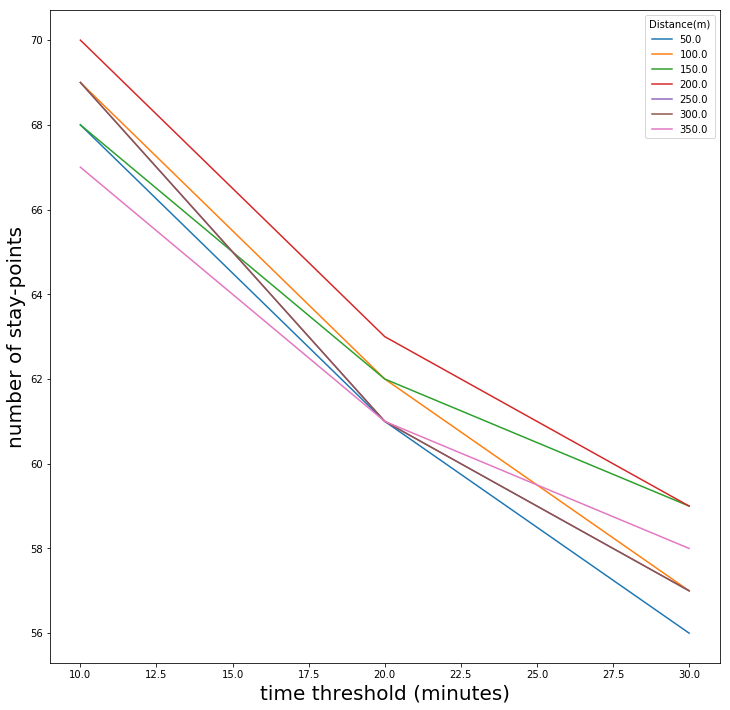

In [25]:

fig, ax = plt.subplots(figsize=(12, 12))

for key, grp in df.groupby(['th_d']):
    ax = grp.plot(ax=ax, kind='line', x='th_t', y='Count', label=key)

plt.legend(loc='best', title="Distance(m)")
plt.ylabel("number of stay-points", fontsize = 20)
plt.xlabel("time threshold (minutes)", fontsize = 20)
plt.show()

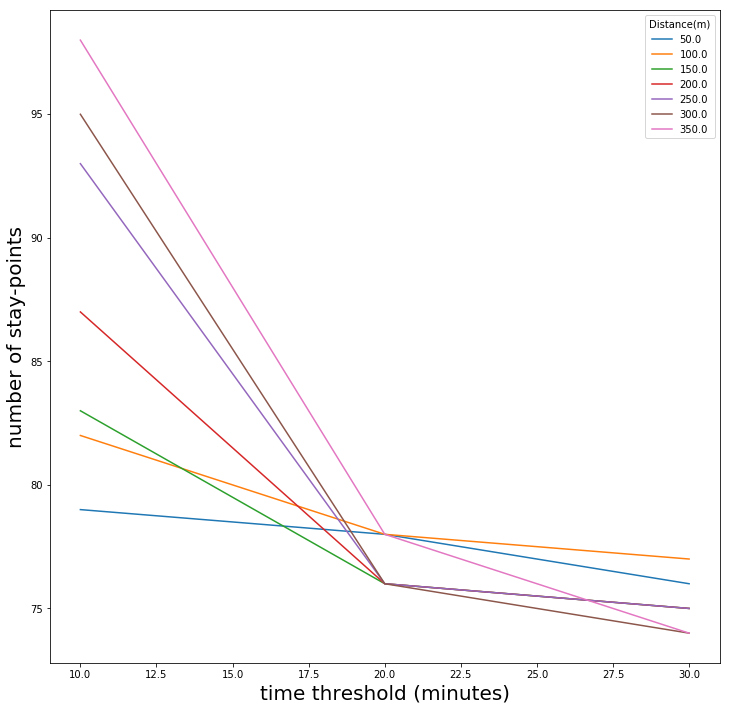

In [27]:

fig, ax = plt.subplots(figsize=(12, 12))

for key, grp in df.groupby(['th_d']):
    ax = grp.plot(ax=ax, kind='line', x='th_t', y='Count', label=key)

plt.legend(loc='best', title="Distance(m)")
plt.ylabel("number of stay-points", fontsize = 20)
plt.xlabel("time threshold (minutes)", fontsize = 20)
plt.show()